In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip ./drive/MyDrive/Exploration/dataset.zip -d "./drive/MyDrive/Exploration/"

Archive:  ./drive/MyDrive/Exploration/dataset.zip
replace ./drive/MyDrive/Exploration/dataset/midi2corpus.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
pip install pytorch-fast-transformers

     |████████████████████████████████| 93 kB 1.4 MB/s 
  Created wheel for pytorch-fast-transformers: filename=pytorch_fast_transformers-0.4.0-cp37-cp37m-linux_x86_64.whl size=16714535 sha256=68b79c68bb57a62c9360ba6ac91908ecbae97e5e79ea5f97bf37ec1bdf337d19
  Stored in directory: /root/.cache/pip/wheels/ae/0c/0f/9c6ae8f66d2aba27f24e0dff07d49c9e7668139c077c9f6d13
Successfully built pytorch-fast-transformers


In [3]:
import pandas as pd
import numpy as np
import time
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
import matplotlib.pyplot as plt
from fast_transformers.builders import TransformerEncoderBuilder
from fast_transformers.masking import TriangularCausalMask

In [4]:
torch.cuda.empty_cache()

In [5]:
datapath = './drive/MyDrive/Exploration/dataset/representations/uncond/cp/ailab17k_from-scratch_cp'
dictionary = pd.read_pickle(datapath + '/dictionary.pkl')
events2words, words2events = dictionary

tokens = [len(events2words[key]) for key in events2words.keys()]

def load_train_data():
  return np.load(datapath+'/train_data_linear.npz')

In [6]:
# Loading the training data
data_train = load_train_data()

data_train_x = data_train['x']
data_train_y = data_train['y']
data_train_mask = data_train['mask']
total_batches = len(data_train)

# Setting Hyper Parameters
model_dimension = 512
total_layers = 12
total_heads = 8
batch_size = 4
initial_learning_rate = 1e-4
total_eopchs = 1000
max_grad_norm = 3

# Embedding
embedding_dimension = [128, 256, 64, 32, 512, 128, 128]

# Token types
token_types = ['tempo', 'chord', 'bar-beat', 'type', 'pitch', 'duration', 'velocity']

In [7]:
# Transformer Class
class Transformer(nn.Module):
  def __init__(self, tokens):
    super(Transformer, self).__init__()

    self.tokens = tokens
    self.model_dimension = model_dimension
    self.total_layers = total_layers
    self.total_heads = total_heads
    self.embedding_dimension = embedding_dimension
    self.dropout = 0.1
    self.batch_size = batch_size
    self.token_embeddings = nn.ModuleList()
    self.token_linear = nn.ModuleList()
    for i in range(len(token_types)):
      self.token_embeddings.append(Embedding(tokens[i], embedding_dimension[i]))
    self.positional_embedding = PositionalEmbedding(self.model_dimension, self.dropout)
    self.input_linear = nn.Linear(np.sum(self.embedding_dimension), self.model_dimension)
    for i in range(len(token_types)):
      self.token_linear.append(nn.Linear(self.model_dimension, tokens[i]))
    self.concat_type_linear = nn.Linear(self.model_dimension + embedding_dimension[token_types.index('type')], self.model_dimension)
    self.loss = nn.CrossEntropyLoss(reduction='none')
    
    self.transformer_encoder = TransformerEncoderBuilder.from_kwargs(
        n_layers = self.total_layers,
        n_heads = self.total_heads,
        query_dimensions = self.model_dimension//self.total_heads,
        value_dimensions = self.model_dimension//self.total_heads,
        feed_forward_dimensions = 2048,
        activation = 'gelu',
        dropout = self.dropout,
        attention_type = "causal-linear"
    ).get()

  # Computes loss
  def get_loss(self, prediction, target,  loss_mask):
    loss = self.loss(prediction, target)
    loss = loss * loss_mask
    return torch.sum(loss) / torch.sum(loss_mask)

  # Training operation for the neural net on the given set of data batch 
  def train_step(self, x, target, loss_mask):
    # Get token embeddings and positional embeddings
    embeddings = []
    for i in range(len(token_types)):
      embeddings.append(self.token_embeddings[i](x[..., i]))
    concat_embedding = torch.cat(embeddings, dim=-1)
    model_embedding = self.input_linear(concat_embedding)
    positional_embedding = self.positional_embedding(model_embedding)

    # Feed the embeddings into our transformer
    attention_mask = TriangularCausalMask(positional_embedding.size(1), device=x.device)
    h = self.transformer_encoder(positional_embedding, attention_mask)

    # Get the predicted token type
    token_type_index = token_types.index('type')
    predicted_token_type = self.token_linear[token_type_index](h)
    target_token_type = self.token_embeddings[token_type_index](target[..., token_type_index])

    # Get the predicted tokens
    predictions = []
    output = self.concat_type_linear(torch.cat([h, target_token_type], dim=-1))
    for index, token_predictor in enumerate(self.token_linear):
      if index != token_type_index:
        predictions.append(token_predictor(output))
      else:
        predictions.append(predicted_token_type)
    predictions = [prediction[:, ...].permute(0, 2, 1) for prediction in predictions]
    losses = [self.get_loss(predictions[i], target[..., i], loss_mask) for i in range(len(token_types))]
    return losses

  # def inference(self, initial=None):
  #   # If no initial token given use the first bar
  #   if initial is None:
  #     initial = np.array([0, 0, 1, 1, 0, 0, 0])
  #   with torch.no_grad():

      

# Embedding Class
class Embedding(nn.Module):
  def __init__(self, num_embeddings, embedding_dimension):
    super(Embedding, self).__init__()
    self.embedding_dimension = embedding_dimension
    self.embed = nn.Embedding(num_embeddings, embedding_dimension)

  def forward(self, x):
    return self.embed(x) * math.sqrt(self.embedding_dimension)

# Positional Embedding Class
class PositionalEmbedding(nn.Module):
  def __init__(self, model_dimension, dropout, max_len=20000):
    super(PositionalEmbedding, self).__init__()
    self.dropout = nn.Dropout(dropout)

    positional_encoding = torch.zeros(max_len, model_dimension)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    division_term = torch.exp(torch.arange(0, model_dimension, 2).float() * (-math.log(10000.0)/model_dimension))
    positional_encoding[:, 0::2] = torch.sin(position*division_term)
    positional_encoding[:, 1::2] = torch.cos(position*division_term)
    positional_encoding = positional_encoding.unsqueeze(0)
    self.register_buffer('positional_encoding', positional_encoding)

  def forward(self, x):
    x = x + self.positional_encoding[:, :x.size(1), :]
    return self.dropout(x)

In [9]:
def train(neural_net, epochs, optimizer, epoch_losses, epoch_time):
  neural_net.train()
  neural_net.cuda()
  batches = len(data_train_x)//neural_net.batch_size

  for epoch in range(epochs):
    start_time = time.time()
    total_loss = 0
    tokens_tot_loss = [0]*len(token_types)
    for batch_index in range(batches):
      batch_start_index = neural_net.batch_size*batch_index
      batch_end_index = neural_net.batch_size*(batch_index + 1)
      batch_x = torch.from_numpy(data_train_x[batch_start_index:batch_end_index]).long().cuda()
      batch_y = torch.from_numpy(data_train_y[batch_start_index:batch_end_index]).long().cuda()
      batch_mask = torch.from_numpy(data_train_mask[batch_start_index:batch_end_index]).float().cuda()

      neural_net.zero_grad()
      losses = neural_net.train_step(batch_x, batch_y, batch_mask)
      loss = (losses[0] + losses[1] + losses[2] + losses[3] + losses[4] + losses[5] + losses[6])/len(token_types)
      for i in range(len(token_types)):
        tokens_tot_loss[i] += losses[i].item()
      loss.backward()
      utils.clip_grad_norm_(get_parameters(neural_net), max_grad_norm)
      optimizer.step()

      print(f'Batch: {batch_index+1}/{batches} | Total Loss: {loss} |' + 
            f'Individual Loss: {losses[0]}, {losses[1]}, {losses[2]}, {losses[3]}, {losses[4]}, {losses[5]}, {losses[6]}') 

      total_loss += loss.item()

    total_loss /= batches
    record_losses = [loss/batches for loss in tokens_tot_loss]
    record_losses.append(total_loss)
    epoch_losses.append(record_losses)
    epoch_time.append(time.time()-start_time)
    print(f'Epoch Loss: {total_loss} | Epoch Time: {time.time()-start_time}') 

In [10]:
import json
model_path = './drive/MyDrive/Exploration/trained_model'

# Save the model
def save_model(model, epoch, losses, time):
  torch.save(model.state_dict(), model_path + '/epoch_{}'.format(str(epoch)))
  data = {
      'losses':losses,
      'time':time
  }
  with open(model_path + '/epoch_{}_metadata.json'.format(str(epoch)), 'w') as file:
    json.dump(data, file, indent=2)

def load_model(epoch):
  model = Transformer(tokens)
  model.load_state_dict(torch.load(model_path + '/epoch_{}'.format(str(epoch))))
  return model.eval()

def get_model_metadata(epoch):
  with open(model_path + '/epoch_{}_metadata.json'.format(str(epoch)), 'r') as file:
    return json.load(file)

In [8]:
def get_parameters(model):
  return filter(lambda param: param.requires_grad, model.parameters())

# Defining Neural Network
music_transformer = Transformer(tokens)
music_transformer_losses = []
music_transformer_time = []
# Defining Optimizer
optimizer = optim.Adam(get_parameters(music_transformer), lr=initial_learning_rate)

In [12]:
# Working with previously trained model
model_test = load_model(70)
model_metadata = get_model_metadata(70)
losses = model_metadata['losses']
times = model_metadata['time']
optimizer_test = optim.Adam(get_parameters(model_test), lr=initial_learning_rate)
# After training using below line the total epochs will be 70 + 20
# train(model_test, 20, optimizer_test, losses, times)

In [52]:
# Train and save model
# NOTE: To note the epochs of saved model add total epochs ran previously (if you are loading a model) and total that will be run below
train(music_transformer, 30, optimizer, music_transformer_losses, music_transformer_time)
save_model(music_transformer, 30, music_transformer_losses, music_transformer_time)

Batch: 1/406 | Total Loss: 0.8430055379867554 |Individual Loss: 0.4407152831554413, 0.4272226393222809, 0.44971948862075806, 0.31527093052864075, 1.6082475185394287, 1.2343779802322388, 1.4254847764968872
Batch: 2/406 | Total Loss: 0.8480960726737976 |Individual Loss: 0.4642959237098694, 0.329854279756546, 0.4374184310436249, 0.33966386318206787, 1.5597363710403442, 1.234112024307251, 1.5715912580490112
Batch: 3/406 | Total Loss: 0.7685045003890991 |Individual Loss: 0.30057817697525024, 0.352232962846756, 0.37365201115608215, 0.32173585891723633, 1.411957859992981, 1.1494230031967163, 1.4699515104293823
Batch: 4/406 | Total Loss: 0.8437100052833557 |Individual Loss: 0.30995339155197144, 0.259349524974823, 0.40577200055122375, 0.39373549818992615, 1.6767373085021973, 1.2351160049438477, 1.6253058910369873
Batch: 5/406 | Total Loss: 0.7964752912521362 |Individual Loss: 0.32983648777008057, 0.3451268672943115, 0.3688409924507141, 0.3280838131904602, 1.5029635429382324, 1.1940046548843384,

In [13]:
# Plot Losses vs Epoch
def visualize_model(model, model_metadata):
  fig, axes = plt.subplots(1, 8, figsize=(25, 5))
  losses = np.array(model_metadata['losses'])
  times = model_metadata['time']
  losses_types = [token_type for token_type in token_types]
  losses_types.append('average')
  for i in range(len(token_types)+1):
    axes[i].plot(losses[:,i])
    axes[i].set_title(f'{losses_types[i]} loss vs epoch')

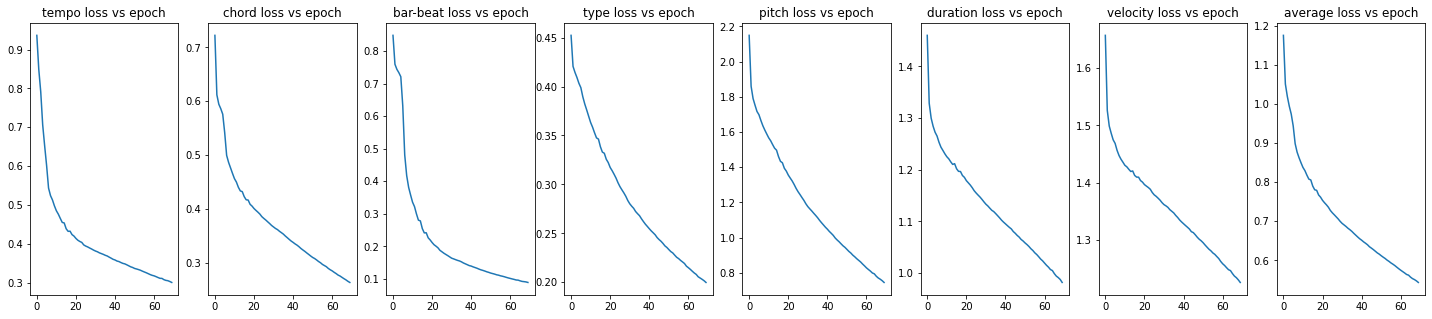

In [14]:
visualize_model(model_test, model_metadata)

In [ ]:
composed_dir = 'composed_music'
tot_composings = 2

In [ ]:
def compose(neural_net):
  neural_net.cuda()
  neural_net.eval()
  os.makedirs(composed_music, exist_ok=True)
  music_time_list = []
  music_words_count_list = []
  for i in range(tot_composings):
    start_time = time.time()
    music = music_transformer.inference(dictionary)
    convert_to_midi(music, composed_dir + '/composing_{}.mid'.format(str(i)))
    music_time_list.append(time.time()-start_time)
    music_words_count.append(len(music))


total    : 17071734784
free     : 693895168
used     : 16377839616


In [ ]:
# Analysing data

print(dictionary[0].keys())
print(dictionary[1].keys())
print(tokens)


print(f'Train X: {(data_train_x.shape)} | Train Y: {(data_train_y.shape)} | Mask: {(data_train_mask.shape)}')
print(total_batches)

print(data_train_x[0][1])
print(data_train_y[0][1])


dict_keys(['tempo', 'chord', 'bar-beat', 'type', 'pitch', 'duration', 'velocity'])
dict_keys(['tempo', 'chord', 'bar-beat', 'type', 'pitch', 'duration', 'velocity'])
[56, 135, 18, 3, 87, 18, 25]
Train X: (1625, 3584, 7) | Train Y: (1625, 3584, 7) | Mask: (1625, 3584)
5
[12 37  2  1  0  0  0]
[ 0  0  0  2 24 17 12]
